# Problem Set IX: Let's Write a 2PCF Code! (Solutions)

*LSST DSFP Session 21*

*Instructor: Lehman Garrison (https://github.com/lgarrison)*

**Overview**

The two-point correlation function (2PCF) is a fundamental statistical measure in cosmology. It encodes completely the information content of Gaussian random fields, which is exactly what the cosmological matter distribution looks like on large scales. Computationally, the 2PCF reduces to counting pairs of galaxies as a function of separation. This can give the CPU quite a workout! Let's try implementing and optimizing this calculation.

**Goals**

In this problem set, you'll practice:
- implementing a 2PCF algorithm in Python,
- analyzing the time and space complexity of the algorithm,
- converting the implementation to NumPy,
- accelerating the computation with Numba,
- interpreting the cosmological significance of the 2PCF.

## Introduction to the 2PCF

Let's break down the 2PCF, called $\xi(r)$. It gives the excess probability over random of finding a galaxy at distance $r$ away from another galaxy.  We compute this probability by counting how many galaxies are separated by distance $r$ in some narrow bins of $r$—essentially histogramming, or binning, the separations—and dividing by the number we expected.

This is illustrated in [the following video](./Two-point-correlation-function-astronomy.webm) from [CAASTRO](http://caastro.org/research-highlights/science-animations/):

<video width="384" height="216" controls>
  <source src="./Two-point-correlation-function-astronomy.webm">
</video>

via [Wikimedia](https://upload.wikimedia.org/wikipedia/commons/c/c0/Two-point-correlation-function-astronomy.webm).

We can think about computing this as a double `for` loop over galaxy positions. That is, for each galaxy $i$, loop over all other galaxies $j$ and compute the distance between $i$ and $i$, called $d_{ij}$. Then find the histogram bin that $d_{ij}$ falls into, and increment that count. The histogram itself should run from 0 to $R_{\rm max}$, with bins of size $dR$.

To get from the histogram to $\xi(r)$, the last piece is to divide the histogram by the expected counts for a uniform random distribution of galaxies. In cosmology nomenclature, if we call the histogram ${\rm DD}(r)$ and the expected number of random counts ${\rm RR}(r)$, then the 2PCF is:

$$
\xi(r) = \frac{{\rm DD}(r)}{{\rm RR}(r)} - 1, \\
{\rm RR}(r) = \frac{4\pi\bar n N}{3}\left ((r + dR)^3 - r^3\right ),\\
\bar n = \frac{N - 1}{L^3},
$$

for $N$ galaxies in a periodic box of side length $L$.

<details>
<summary>Technical details</summary>

The $RR$ term is the mean galaxy density $\bar n$ times the volume of a spherical shell from radius $r$ to $r + dR$.  The "minus 1" in $\bar n$ arises from the fact that when sitting on one galaxy, only $N-1$ galaxies are available to make a pair. The "minus 1" in $\xi(r)$ arises from the definition as excess probabilty over random. That is, an unclustered distribution has $\xi(r) = 0$. 

</details>

## A Python 2PCF Implementation

Let's start by implementing the 2PCF with Python `for` loops. We'll use a data set of "real fake" galaxies (actually halos from an $N$-body simulation). The `load_galaxies()` function loads these positions; there's nothing you need to fill in there.

Fill in the `compute_2pcf()` function below. The parts marked by `# YOUR CODE HERE` are where you should add the missing code.

In [1]:
import numpy as np
import astropy.io.ascii


def load_galaxies(fn, N=None):
    """Load galaxy positions from a file and return a random subset of size N,
    or all of them if N is None. The returned array has shape (N, 3).
    The box size is also returned.
    """
    table = astropy.io.ascii.read(fn)
    arr = np.array([table['x'], table['y'], table['z']]).T
    L = table.meta['L']
    if N is not None:
        rng = np.random.default_rng(123)
        arr = rng.choice(arr, N, replace=False)

    return np.ascontiguousarray(arr), L

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
def compute_2pcf(points, R_max, N_bin):
    """Compute separations between all pairs of points and histogram
    the separations.
    """
    N = len(points)
    dR = R_max / N_bin  # hint: you'll use this below
    
    # the histogram of separations
    sep_hist = np.zeros(N_bin, dtype=np.int64)
    
    for i in range(N):
        for j in range(N):
            dpos = points[i] - points[j]  # YOUR CODE HERE
            
            dpos -= L * np.rint(dpos / L)  # periodic wrap
            
            d_ij = np.sqrt(np.sum(dpos ** 2))  # YOUR CODE HERE
            bin_idx = int(d_ij / dR)  # YOUR CODE HERE
            
            if bin_idx < N_bin:
                sep_hist[bin_idx] += 1

    sep_hist[0] -= N  # remove self-pairs
    hist_edges = np.linspace(0, R_max, N_bin + 1)
    RR = N * (N - 1) / L ** 3 * 4/3 * np.pi * (hist_edges[1:]**3 - hist_edges[:-1]**3)

    xi = sep_hist / RR - 1  # YOUR CODE HERE

    return xi


pos, L = load_galaxies('galaxies.ecsv', N=1500)
R_max, N_bin = 150.0, 20
xi = compute_2pcf(pos, R_max, N_bin)

This version will probably take about 25 seconds to run.

### Plot the result

Now that we have a result, let's plot it to make sure it looks sensible before we move onto optimization. Use matplotlib below to plot $\xi(r)$ versus $r$. We'll use a mixed log-linear y-scale ("symlog") to allow for negative y values.

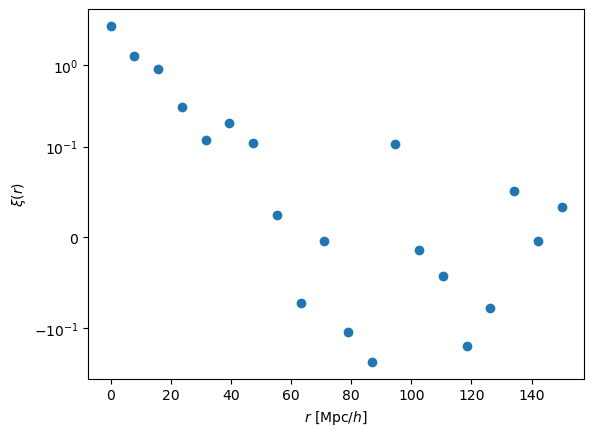

In [3]:
import matplotlib.pyplot as plt

def plot_xi(xi, R_max, N_bin):
    fig, ax = plt.subplots()

    R = np.linspace(0, R_max, N_bin)  # YOUR CODE HERE
    
    ax.plot(R, xi, marker='o', ls='none')  # YOUR CODE HERE
    
    ax.set_xlabel(r"$r$ [Mpc/$h$]")
    ax.set_ylabel(r"$\xi(r)$")

    ax.set_yscale('symlog', linthresh=0.1)

plot_xi(xi, R_max, N_bin)

If all goes well, your plot should look something like the following:

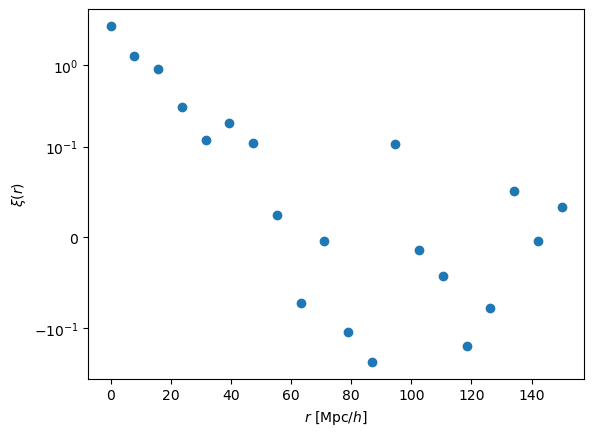

We see a positive clustering signal on small scales (< 20 Mpc/$h$), and mostly noise on large scales, although we may be able to resolve a signal with more galaxies. But first we need a faster implementation!

### Analyze the Algorithm

30 seconds is pretty slow for just 1500 galaxies. Part of the problem lies in the computational complexity of the problem; that is, the scaling the number of operations as a function of $N$. Because of the double `for` loop, the computational complexity of this algorithm is $\mathcal{O}(N^2)$, meaning the cost rises as the square of the $N$ in the limit of large $N$. Usually one is stuck with $\mathcal{O}(N^2)$ for the 2PCF, and the best you can do is make it as fast as possible.

Similar to computational complexity, we can also analyze the *space complexity*. This refers to how much memory the algorithm allocates as a function of $N$. If the amount of space is independent of $N$, then it has space complexity $\mathcal{O}(1)$; if it allocates memory in proportion to the number of galaxies, it has complexity $\mathcal{O}(N)$; and so on.

**Quiz**

What is the space complexity of this implementation?

1. $\mathcal{O}(1)$
1. $\mathcal{O}(N)$
1. $\mathcal{O}(N^2)$
1. $\mathcal{O}(N^3)$

<details>
<summary>Click here to reveal the answer</summary>

The answer is $\mathcal{O}(1)$! The amount of space for the algorithm is independent of the size of the input dataset. The only allocations are single variables like `d_ij`, or constant-size arrays like `sep_hist`.

</details>

## NumPy 2PCF Implementation

Even given the $\mathcal{O}(N^2)$ time complexity, we should be able to do better than 30 seconds. After all, $1500^2$ is only 2 million loop iterations, which isn't very many for a computer that operates at billions of cycles per second (and the body of the loop isn't *that* intensive).

As we saw during the lecture, maybe we can do better with NumPy. Fill out the `numpy_compute_2pcf()` function below without using any Python `for` loops.

Give it a try, but if you get stuck, click on the button below for a hint.
<details>
<summary>Click here for a hint</summary>

`pos` has shape `(N,3)`, and to avoid using `for` loops, we need to create an array of position differences between all `N**2` pairs of particles. This means creating an array of shape `(N,N,3)`. You'll need to use NumPy array broadcasting to achieve this!

</details>

In [4]:
def numpy_compute_2pcf(pos, R_max, N_bin):
    N = len(pos)
    
    delta = pos[:, None] - pos # YOUR CODE HERE
    delta -= L * np.rint(delta / L)  # periodic wrap

    d_ij = np.sqrt(np.sum(delta ** 2, axis=-1))  # YOUR CODE HERE

    hist_edges = np.linspace(0, R_max, N_bin + 1)
    sep_hist = np.histogram(d_ij.flat, bins=hist_edges)[0]  # YOUR CODE HERE

    sep_hist[0] -= N  # remove self-pairs

    RR = N * (N - 1) / L ** 3 * 4/3 * np.pi * (hist_edges[1:]**3 - hist_edges[:-1]**3)

    xi = sep_hist / RR - 1

    return xi

numpy_xi = numpy_compute_2pcf(pos, R_max, N_bin)

### Check the correctness

When you think you got the answer right, compare it to the previous version with the following cell.

(This highlights an important principle in optimization, which is to get an unoptimized version working first so you can be confident in the correctness of your optimizations!)

In [5]:
np.allclose(xi, numpy_xi)

True

### Time the function

The function should feel pretty fast, so go ahead and time it:

In [6]:
%timeit numpy_compute_2pcf(pos, R_max, N_bin)

100 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


It should take around 100 ms. That's a 300x improvement!

### Plot a better measurement
In fact, it's so fast that we can plot the results from a bigger dataset:

In [7]:
pos, L = load_galaxies('galaxies.ecsv', N=10_000)
numpy_xi = numpy_compute_2pcf(pos, R_max, N_bin)

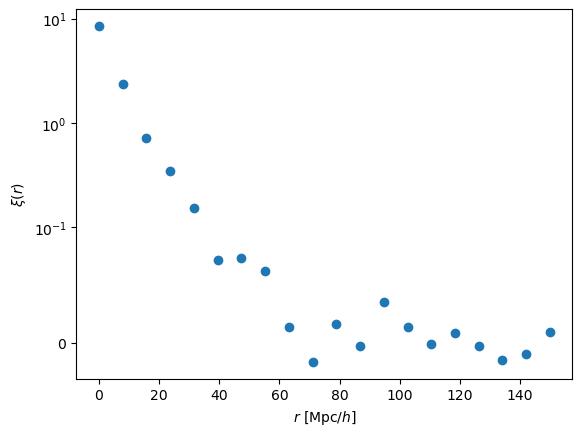

In [8]:
plot_xi(numpy_xi, R_max, N_bin)

The result is definitely less noisy; we're resolving clustering out to 60 Mpc/$h$ before it gets noisy.

But we can do better with a faster algorithm! In fact, we need to do better, because there may be an interesting signal in the clustering at larger scales...

### Analyze the Algorithm

Before we move on, analyze the space complexity of your NumPy algorithm (the time complexity is still $\mathcal{O}(N^2)$).

**Quiz**

What is the space complexity of your NumPy implementation?

1. $\mathcal{O}(1)$
1. $\mathcal{O}(N)$
1. $\mathcal{O}(N^2)$
1. $\mathcal{O}(N^3)$

<details>
<summary>Click here for the answer</summary>

The space complexity is $\mathcal{O}(N^2)$, because we created a temporary array of shape `(N,N,3)`. This was fine for small (`N < 10_000`) datasets, but if we went much larger, we would start consuming dozens of GB of memory.

</details>

## A Numba 2PCF Implementation

Now let's implement this in Numba. We want to take advantage of Numba's ability to use `for` loops efficiently, so we'll use the Python implementation as a starting point.

There's one very important optimization to make that we haven't talked about yet, and that's using the fact that we know that we're dealing with 3 coordinates (x, y, z). That is, our arrays have shape `(N,3)`, so instead of writing shape-agnostic code like

```python
delta = points[i] - points[j]
```

we should write shape-specific code like

```python
dx = points[i,0] - points[j,0]
dy = points[i,1] - points[j,1]
dz = points[i,2] - points[j,2]
```

It's more verbose, but the speedup is worth it! This optimization lets Numba eliminate dynamic array allocation in the inner loop.

In [9]:
import numba

@numba.njit
def numba_compute_2pcf(points, R_max, N_bin):
    N = len(points)
    dR = R_max / N_bin
    
    # the histogram of separations
    sep_hist = np.zeros(N_bin, dtype=np.int64)
    
    for i in range(N):
        for j in range(N):
            # YOUR CODE HERE
            dx = points[i, 0] - points[j, 0]
            dy = points[i, 1] - points[j, 1]
            dz = points[i, 2] - points[j, 2]
            
            # YOUR CODE HERE
            dx -= L * np.rint(dx / L)
            dy -= L * np.rint(dy / L)
            dz -= L * np.rint(dz / L)
            
            d_ij = np.sqrt(dx**2 + dy**2 + dz**2)  # YOUR CODE HERE

            bin_idx = int(d_ij / dR)  # YOUR CODE HERE
            
            if bin_idx < N_bin:
                sep_hist[bin_idx] += 1

    sep_hist[0] -= N  # remove self-pairs
    hist_edges = np.linspace(0, R_max, N_bin + 1)
    RR = N * (N - 1) / L ** 3 * 4/3 * np.pi * (hist_edges[1:]**3 - hist_edges[:-1]**3)

    xi = sep_hist / RR - 1

    return xi

And check the correctness:

In [10]:
np.allclose(numba_compute_2pcf(pos, R_max, N_bin), numpy_xi)

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


True

And compare the timing against NumPy (we're using more points now, so NumPy should take around 5 seconds):

In [11]:
%timeit numpy_compute_2pcf(pos, R_max, N_bin)

4.4 s ± 5.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%timeit numba_compute_2pcf(pos, R_max, N_bin)

878 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Numba should take around 800 ms, a 6x speedup!  We're now over 2000x faster than the original version.

Note that the space complexity is back to $\mathcal{O}(1)$. This is great for RAM usage, but is also a key reason why Numba is so much better than Numpy at this problem. There's no expensive movement of large temporary arrays back and forth to main memory.

### Optimize (Bonus)
There are lots of optimizations that are still possible! Here are some ideas, in order from easy to hard:
1. Numba has a `@numba.njit(fastmath=True)` mode that relaxes the tolerance on expensive functions like `sqrt` (usually the loss of accuracy is acceptable). Try it out! Does the result change? Does the performance?
1. We visited every pair twice, once with `i` as the "primary" and once with `j`. Can you figure out how to only visit each pair once?
1. `sqrt` is a classically expensive operation on the CPU. Can you figure out how to do fewer `sqrt` evaluations?
1. Parallelize the computation using `nb.prange()`. Warning: Numba will **not** automatically perform parallel reductions on the histogram array, so you need to figure out how to have a separate histogram for every thread and sum the results at the end.

See my [fast version](#lehmans-fast-parallel-version) below that implements these tricks in the solution!

###  Run on the Full Dataset
Take your most optimized version and run on as big a dataset as you can. If you haven't done any bonus optimizations, then 80K points is a good size and should run in about 1 minute.  If you have a faster version, try the full dataset of 135K points.

In [13]:
pos = load_galaxies('galaxies.ecsv', N=80_000)[0]
numba_xi = numba_compute_2pcf(pos, R_max, N_bin)

### What's Hiding in the Clustering?

Plot the result. It should now look smooth all the way out to `R_max`. But what's that bump at 100 Mpc/$h$?

**Quiz**

What is the clustering enhancement in the galaxy distribution at 100 Mpc/$h$?

<details>
<summary>Click here for the answer</summary>

That's the baryon acoustic oscillation (BAO) peak! This is an imprint in the galaxy distribution leftover from sound waves propagating in the CMB prior to recombination. The location of this peak serves as a standard ruler, letting us measure the distance-redshift relation across cosmic time.

LSST, while not a dedicated large-scale structure experiment, will measure enough galaxy positions to enable highly constraining BAO science using the 2PCF alone. And with billions of galaxies, they'd better have a fast 2PCF implementation!

</details>

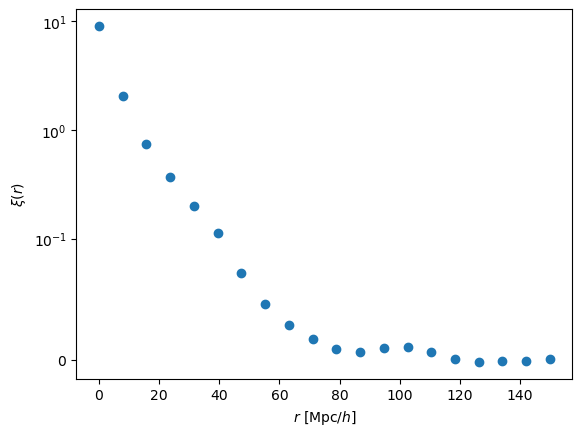

In [14]:
plot_xi(numba_xi, R_max, N_bin)

## Lehman's Fast Parallel Version

Check the solution if you want to see my fastest parallel Numba implementation! It's about 4x faster without threading, and using 12 threads can run the whole dataset in 7 seconds.

Note that if you want to try out parallelism yourself, then the free Google Colab runtimes are not a good option, as they only give you one physical CPU core. You'll want to use your laptop, a cluster, Binder, etc.

In [15]:
import numba

numba.set_num_threads(12)

@numba.njit(parallel=True, fastmath=True)
def numba_compute_2pcf_fast(points, R_max, N_bin):
    N = len(points)
    dR = R_max / N_bin
    
    # the histogram of separations
    N_thread = numba.get_num_threads()
    sep_hist = np.zeros((N_thread,N_bin), dtype=np.int64)
    
    R_max2 = R_max**2
    for i in numba.prange(N):
        t = numba.get_thread_id()
        for j in range(i + 1, N):
            dx = points[i, 0] - points[j, 0]
            dy = points[i, 1] - points[j, 1]
            dz = points[i, 2] - points[j, 2]
            
            dx -= L * np.rint(dx / L)
            dy -= L * np.rint(dy / L)
            dz -= L * np.rint(dz / L)
            
            d_ij2 = dx**2 + dy**2 + dz**2

            if d_ij2 > R_max2:
                continue
            
            d_ij = np.sqrt(d_ij2)
            bin_idx = int(d_ij / dR)
            
            if bin_idx < N_bin:
                sep_hist[t,bin_idx] += 2

    sep_hist = np.sum(sep_hist, axis=0)
    hist_edges = np.linspace(0, R_max, N_bin + 1)
    RR = N * (N - 1) / L ** 3 * 4/3 * np.pi * (hist_edges[1:]**3 - hist_edges[:-1]**3)

    xi = sep_hist / RR - 1

    return xi


In [16]:
pos = load_galaxies('galaxies.ecsv', N=None)[0]
%timeit numba_compute_2pcf_fast(pos, R_max, N_bin)

6.86 s ± 98.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Epilogue

The major optimization that we didn't use in any of the above implementations (including my fast, parallel one) is spatial partitioning. The 2PCF runtime is dominated by pairs at large separation, typically much larger than `R_max`. A partitioning scheme, like a grid or a tree, divides the space into regions and only computes point separations between regions that are close enough to satisfy the `R_max` condition. All major 2PCF codes use spatial partitioning as a pre-processing step to the kind of $N^2$ algorithm we wrote above.

Modern, fast 2PCF codes include [treecorr](https://rmjarvis.github.io/TreeCorr/_build/html/index.html), [FCFC](https://github.com/cheng-zhao/FCFC/), and [Corrfunc](https://github.com/manodeep/corrfunc) (of which I'm a co-author). Also, if you're interested in what a fast Numba implementation looks like that includes a spatial partitioner, check out my [numba-2pcf](https://github.com/lgarrison/numba-2pcf) project.